In [1]:
#データの読み込み
import numpy as np
import pandas as pd 
from config import Config

<head>
<h1>目次</h1>
</head>
<body>
    <p><h4><a href="aa">1.データの抽出</a></h4></p>
    <p><h4>2.データ意味の確認</h4></p>
    <p><h4>3.データ品質の確認</h4></p>
    <p><h4>4.データ処理方法の考察</h4></p>
</body>

<head>
    <b><a id="aa">1.データ抽出</a></b>
    <base href="C:\Users\dso-s.gao\Desktop￥" > 
</head>
<body>
    <p><b>目的：サンプル走行データの読み込み。pandasデータフレームにする</b></p>
    <hr />
    <p></p>
</body>

In [2]:
#dataの保存先絶対パスを取得
opt = Config()
data_path_aions = getattr(opt, "data_path_aions")
data_path_gs3 = getattr(opt, "data_path_gs3")
data_path_gs4 = getattr(opt, "data_path_gs4")

In [3]:
#走行データ読み込み。データフレームにする
def readtable(abspath, headerpath=opt.header_path_gs3):
    
    """
    path:データの保存先の絶対パス
    """
    data = pd.read_table(abspath + "/all.txt", header=None)
    
    if headerpath:
        with open(abspath +  headerpath) as f:
            header = f.read()
            header = [i.strip() for i in header.split(",")]
        data.columns = header 
    return data 

In [4]:
#gs3の車データを読み込み
gs3_data = readtable(data_path_gs3) 

<head>
<t><b>2.データ意味の確認</b></t>
</head>
<body>
<p>gs3_data</p>
    <ol>
        <li>VIN: 車台番号</li>
        <li>timestamp: 時刻</li>
        <li>bos_vehspd:速度</li>
        <li>bcs_vehspdvd:速度有効かどうか</li>
        <li>bcs_actvehlaltrlaccel:右左加速度</li>
        <li>bcs_ActVehLongAccel:上下加速度</li>
        <li>sas_SteeringAngleSpd</li>
        <li>TEL_LatitudeDeg:度</li>
        <li>TEL_LatitudeMin:分</li>
        <li>TEL_LatitudeSec:秒</li>
        <li>TEL_LongitudeDeg:度</li>
        <li>TEL_LongitudeMin:分</li>
        <li>TEL_LongitudeSec:秒</li>
        <li>ICM_TotalOdometer:累計運転距離</li>
        <li>BCM_KeySt:エンジンON＝OFF </li>
    </ol>
</body>
<hr />

<head>
    <b>3.データ品質の確認</b>
    <base href="C:\Users\dso-s.gao\Desktop￥" > 
</head>
<body>
    <p>
        <b>目的：サンプルデータの欠損率、異常値を確認、欠損処理、異常値処理を行う</b>
        <br>
        <a href="https://confluence.adi-datasol.com/pages/viewpage.action?pageId=2951175">参考)タフツの前処理方法</a>
        <br>
    <p>
        <b>データの全体的な特徴を把握するために以下の項目を集計する.</b>
        <br>1.VINの数
        <br><del>2.車種ごとのVINの数</del> => gs3一車種のため
        <br>3.レコードの重複
        <br>4.VINとデータの取得時刻（data_acq_time）の組でレコードが一意に決まるか
        <br>5.カラムごとの欠損状況
        <br>6.カラムごとのヒストグラム
    </p>
 <hr/>
    <p></p>
</body>

In [5]:
#１．VINの数を確認
print("VINの数", gs3_data["vin"].nunique())

VINの数 10


In [6]:
#3.レコードの重複 
#4.VINとデータの取得時刻（data_acq_time）の組でレコードが一意に決まるか
gs3_data[gs3_data.groupby(["vin", "timestamp"], as_index=False)["bcs_vehspd"].count()["bcs_vehspd"] >= 2]

,vin,timestamp,bcs_vehspd,bcs_vehspdvd,bcs_actvehlaltrlaccel,bcs_ActVehLongAccel,sas_SteeringAngleSpd,TEL_LatitudeDeg,TEL_LatitudeMin,TEL_LatitudeSec,TEL_LongitudeDeg,TEL_LongitudeMin,TEL_LongitudeSec,ICM_TotalOdometer,BCM_KeySt


In [7]:
#5.カラムごとの欠損状況
print("欠損データの数")
print(gs3_data.isnull().sum()) # => 欠損データの数
print("========================================")
print("欠損率")
print(gs3_data.isnull().sum() / len(gs3_data))

欠損データの数
vin                            0
timestamp                      0
bcs_vehspd                    60
bcs_vehspdvd             1607049
bcs_actvehlaltrlaccel         60
bcs_ActVehLongAccel           60
sas_SteeringAngleSpd          60
TEL_LatitudeDeg               60
TEL_LatitudeMin               60
TEL_LatitudeSec               60
TEL_LongitudeDeg              60
TEL_LongitudeMin              60
TEL_LongitudeSec              60
ICM_TotalOdometer             60
BCM_KeySt                     60
dtype: int64
欠損率
vin                      0.000000
timestamp                0.000000
bcs_vehspd               0.000037
bcs_vehspdvd             0.982771
bcs_actvehlaltrlaccel    0.000037
bcs_ActVehLongAccel      0.000037
sas_SteeringAngleSpd     0.000037
TEL_LatitudeDeg          0.000037
TEL_LatitudeMin          0.000037
TEL_LatitudeSec          0.000037
TEL_LongitudeDeg         0.000037
TEL_LongitudeMin         0.000037
TEL_LongitudeSec         0.000037
ICM_TotalOdometer        0.000037
BCM_

In [33]:
#6.カラムごとのヒストグラム
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 
import visdom

#カラムごとのヒストグラムをplotする
def plotdist(env, column, data):
    vis = visdom.Visdom(env=env)
    return vis.histogram(
                data[data[column].notnull()][column], 
                win= column + "pane_name", 
                opts={
                    "numbins":20, 
                    "title": column, 
                    "ylabel":"Count"
                    })

In [35]:
#集計図をlocalhost:8097で確認
for column in gs3_data.columns:
    
    if column != "vin": 
        plotdist("gs3_data", column=column, data=gs3_data)

Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...


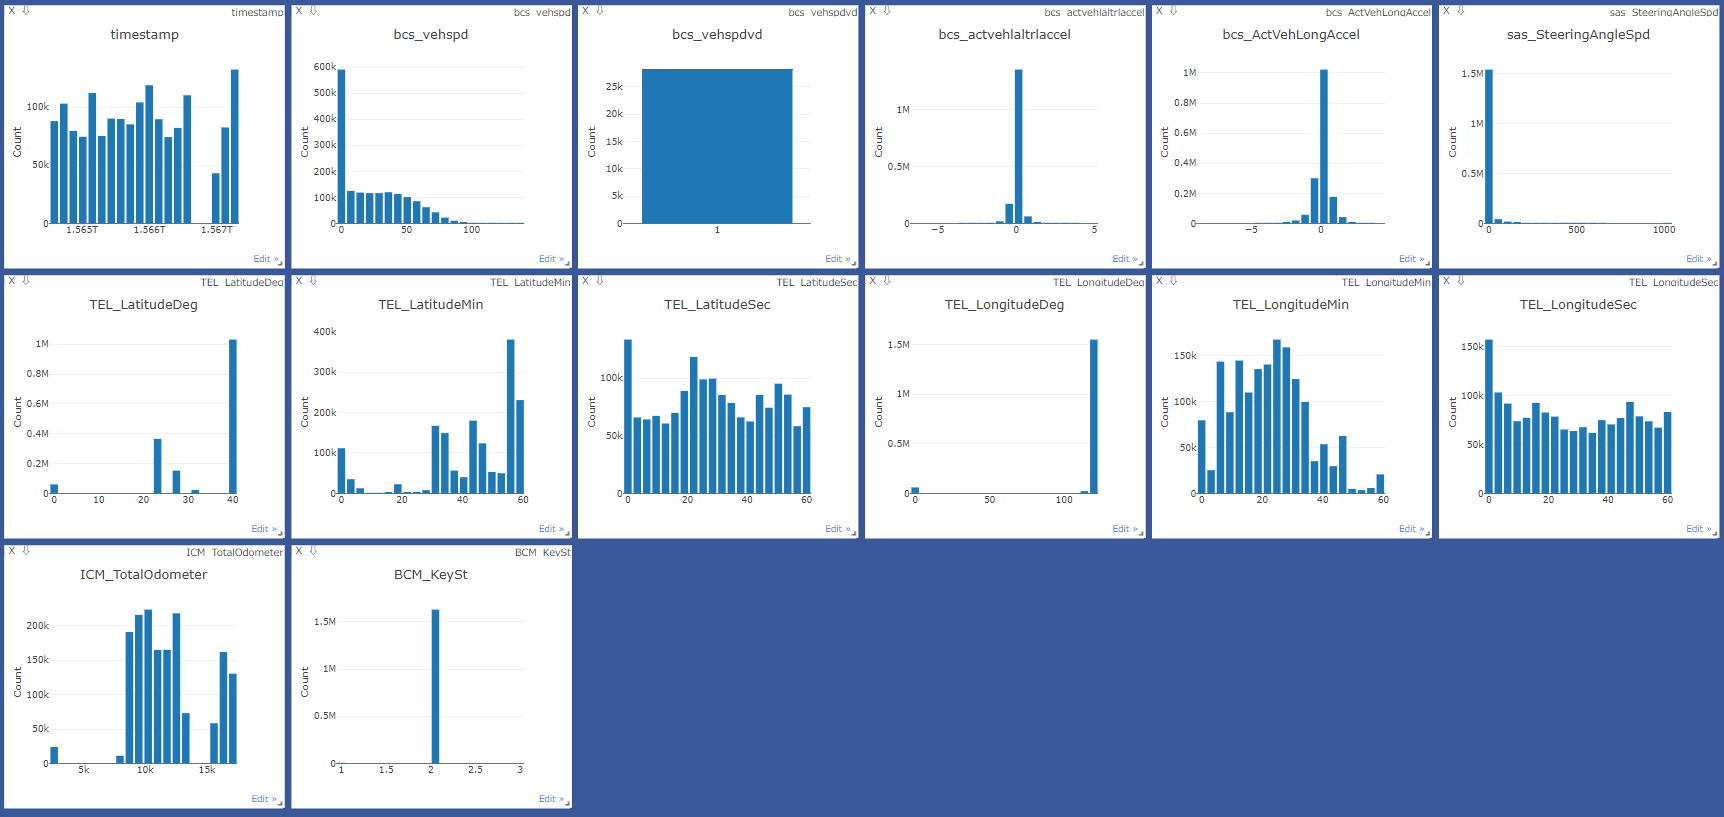

In [48]:
#集計図
from PIL import Image
Image.open("/home/gaosi/syukei.PNG")

In [50]:
#timestampを時間で変換
gs3_data.head()

,vin,timestamp,bcs_vehspd,bcs_vehspdvd,bcs_actvehlaltrlaccel,bcs_ActVehLongAccel,sas_SteeringAngleSpd,TEL_LatitudeDeg,TEL_LatitudeMin,TEL_LatitudeSec,TEL_LongitudeDeg,TEL_LongitudeMin,TEL_LongitudeSec,ICM_TotalOdometer,BCM_KeySt
0,LMWHP1S20J1000691,1566005435000,9.00000,NaN,0.379656,0.786557,164.0,39.0,56.0,29.77,116.0,41.0,20.30,16259.0,2.0
1,LMWHP1S20J1000691,1566005588000,37.96875,NaN,0.325403,-0.325639,4.0,39.0,56.0,18.03,116.0,41.0,4.76,16260.0,2.0
2,LMWHP1S20J1000691,1566005860000,0.56250,NaN,-0.000118,0.298276,4.0,39.0,55.0,46.50,116.0,40.0,43.38,16261.0,2.0
3,LMWHP1S20J1000691,1566006074000,0.00000,NaN,0.054135,-0.000118,0.0,39.0,55.0,34.43,116.0,40.0,47.24,16261.0,2.0
4,LMWHP1S20J1000691,1566006164000,0.00000,NaN,0.054135,-0.054372,0.0,39.0,55.0,34.40,116.0,40.0,47.27,16261.0,2.0


<head>
<b>4.データ処理方法の考察</b>
</head>
<body>
 <p>
 3.データ
 </p>
<body>

<iframe src="www.baidu.com"></iframe>